In [1]:
import sionna as sn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-06-22 09:57:10.545333: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-22 09:57:10.607111: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 09:57:10.994417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 09:57:10.996257: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 09:57:12.077809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
BATCH_SIZE = 500
NUM_BS_ANT = 8
NUM_UT = 8
NUM_STREAMS_PER_TX = 2

NUM_BITS_PER_SYMBOL = 4
CODERATE = 0.5

BS_HEIGHT = 15.0
MAX_UT_HEIGHT = 300
MIN_UT_HEIGHT = 20.0

CARRIER_FREQUENCY = 1.9e9

In [3]:
rx_tx_association = np.ones([1, NUM_UT])

stream_management = sn.mimo.StreamManagement(
    rx_tx_association=rx_tx_association,
    num_streams_per_tx=NUM_STREAMS_PER_TX 
)

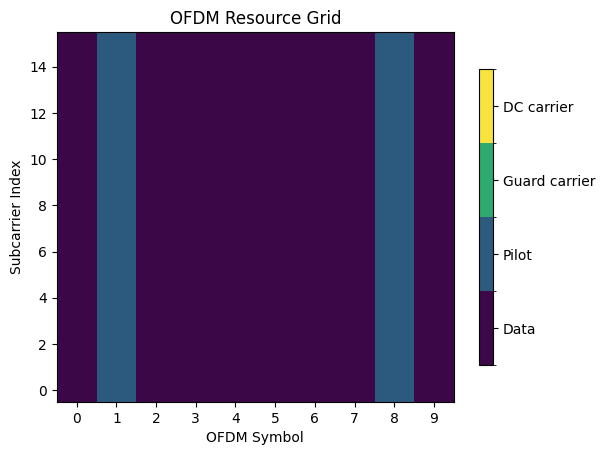

In [4]:
resource_grid = sn.ofdm.ResourceGrid(
    num_ofdm_symbols=10,
    fft_size=16,
    subcarrier_spacing=30e3,
    num_tx=NUM_UT,
    num_streams_per_tx=NUM_STREAMS_PER_TX,
    cyclic_prefix_length=6,
    pilot_pattern="kronecker",
    pilot_ofdm_symbol_indices=[1,8]
)

resource_grid_mapper = sn.ofdm.ResourceGridMapper(resource_grid=resource_grid)
frequencies = sn.channel.subcarrier_frequencies(
    num_subcarriers=resource_grid.fft_size,
    subcarrier_spacing=resource_grid.subcarrier_spacing
)

resource_grid.show();

In [5]:
NUM_CODED_BITS = int(resource_grid.num_data_symbols * NUM_BITS_PER_SYMBOL)
NUM_INFO_BITS = int(NUM_CODED_BITS * CODERATE)


class CellModel(tf.keras.Model):
    
    def __init__(self, scenario='umi'):

        super().__init__()

        self.binary_source = sn.utils.BinarySource()

        constellation = sn.mapping.Constellation('qam', NUM_BITS_PER_SYMBOL)
        self.mapper = sn.mapping.Mapper(constellation=constellation)
        self.demapper = sn.mapping.Demapper('app', constellation=constellation)

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(NUM_INFO_BITS, NUM_CODED_BITS)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=self.encoder, hard_out=True)

        self.ls_est = sn.ofdm.LSChannelEstimator(resource_grid=resource_grid, interpolation_type='nn')

        self.lmmse_equ = sn.ofdm.LMMSEEqualizer(resource_grid=resource_grid, stream_management=stream_management)

        self.channel_freq = sn.channel.ApplyOFDMChannel(add_awgn=True)

        self.ut_array = sn.channel.tr38901.Antenna(
            polarization='dual',
            polarization_type='cross',
            antenna_pattern='omni',
            carrier_frequency=CARRIER_FREQUENCY
        )

        self.bs_array = sn.channel.tr38901.AntennaArray(
            num_rows=1,
            num_cols=NUM_BS_ANT,
            polarization='dual',
            polarization_type='cross',
            antenna_pattern='38.901',
            # antenna_pattern='omni',
            carrier_frequency=CARRIER_FREQUENCY
        )

        topology = sn.channel.gen_single_sector_topology(
            batch_size=BATCH_SIZE,
            indoor_probability=0,
            num_ut=NUM_UT,
            scenario=scenario,
            bs_height=BS_HEIGHT,
            max_ut_height=MAX_UT_HEIGHT,
            min_ut_height=MIN_UT_HEIGHT
        )

        if scenario == 'umi':
            self.channel_model=sn.channel.tr38901.UMi(
                carrier_frequency=CARRIER_FREQUENCY,
                o2i_model='low',
                ut_array=self.ut_array,
                bs_array=self.bs_array,
                direction='uplink',
                enable_pathloss=False,
                enable_shadow_fading=False
            )
        elif scenario == 'uma':
            self.channel_model = sn.channel.tr38901.UMa(
                carrier_frequency=CARRIER_FREQUENCY,
                o2i_model="low",
                ut_array=self.ut_array,
                bs_array=self.bs_array,
                direction='uplink',
                enable_pathloss=False,
                enable_shadow_fading=False
            )
    
        self.channel_model.set_topology(*topology)

    @tf.function
    def __call__(self, batch_size, ebno_db):

        no = sn.utils.ebnodb2no(
            coderate=CODERATE,
            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
            resource_grid=resource_grid,
            ebno_db=ebno_db
        ) 

        bits = self.binary_source([
            batch_size,
            NUM_UT,
            resource_grid.num_streams_per_tx,
            NUM_INFO_BITS
        ])
        coded_bits = self.encoder(bits)
        qam_symbols = self.mapper(coded_bits)
        ofdm_symbols = resource_grid_mapper(qam_symbols)

        a, tau = self.channel_model(
            num_time_samples=resource_grid.num_ofdm_symbols,
            sampling_frequency=1/resource_grid.ofdm_symbol_duration
        )
        h_freq = sn.channel.cir_to_ofdm_channel(
            frequencies=frequencies,
            a=a,
            tau=tau,
            normalize=True
        )
        received_symbols = self.channel_freq([ofdm_symbols, h_freq, no])
        estimation, err_var = self.ls_est([received_symbols, no])
        equalized_symbols, no_eff = self.lmmse_equ([ received_symbols, estimation, err_var, no])
        llr = self.demapper([equalized_symbols, no_eff])
        bits_hat = self.decoder(llr)

        return bits, bits_hat
                

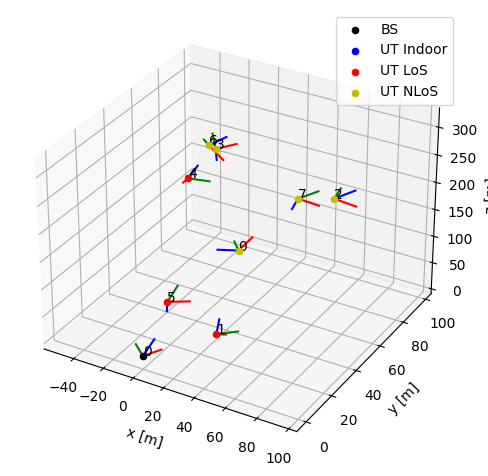

In [6]:
ber_plots = sn.utils.PlotBER('UAV Simulation')
umi_model = CellModel('umi')
uma_model = CellModel('uma')

umi_model.channel_model.show_topology();

In [7]:
ber_plots.simulate(
    umi_model,
    batch_size=BATCH_SIZE,
    ebno_dbs=np.linspace(-5,10,16),
    num_target_bit_errors=1000,
    legend='UMi',
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=False
);

2023-06-22 09:57:15.925906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.0862e-01 | 9.8962e-01 |      632060 |     2048000 |         7917 |        8000 |        26.3 |reached target bit errors
     -4.0 | 2.9635e-01 | 9.7937e-01 |      606930 |     2048000 |         7835 |        8000 |        11.3 |reached target bit errors
     -3.0 | 2.8167e-01 | 9.6200e-01 |      576854 |     2048000 |         7696 |        8000 |        11.2 |reached target bit errors
     -2.0 | 2.6773e-01 | 9.3850e-01 |      548301 |     2048000 |         7508 |        8000 |        11.3 |reached target bit errors
     -1.0 | 2.5743e-01 | 9.2175e-01 |      527226 |     2048000 |      

In [8]:
ber_plots.simulate(
    uma_model,
    batch_size=BATCH_SIZE,
    ebno_dbs=np.linspace(-5,10,16),
    num_target_bit_errors=1000,
    legend='UMa',
    soft_estimates=False,
    max_mc_iter=1000,
    show_fig=False
);

2023-06-22 10:00:38.236529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'batch_size' with dtype int32
	 [[{{node batch_size}}]]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.9416e-01 | 9.2212e-01 |      602431 |     2048000 |         7377 |        8000 |        23.0 |reached target bit errors
     -4.0 | 2.7979e-01 | 8.8525e-01 |      573013 |     2048000 |         7082 |        8000 |        12.1 |reached target bit errors
     -3.0 | 2.6935e-01 | 8.5137e-01 |      551633 |     2048000 |         6811 |        8000 |        11.8 |reached target bit errors
     -2.0 | 2.5914e-01 | 8.2575e-01 |      530716 |     2048000 |         6606 |        8000 |        11.9 |reached target bit errors
     -1.0 | 2.5069e-01 | 8.0175e-01 |      513416 |     2048000 |         6414 |        8000 |        11.9 |reached target bit errors
      0.0 | 2.4252e-01 | 7.7912e-01 |      496678 |     2048000 |         6

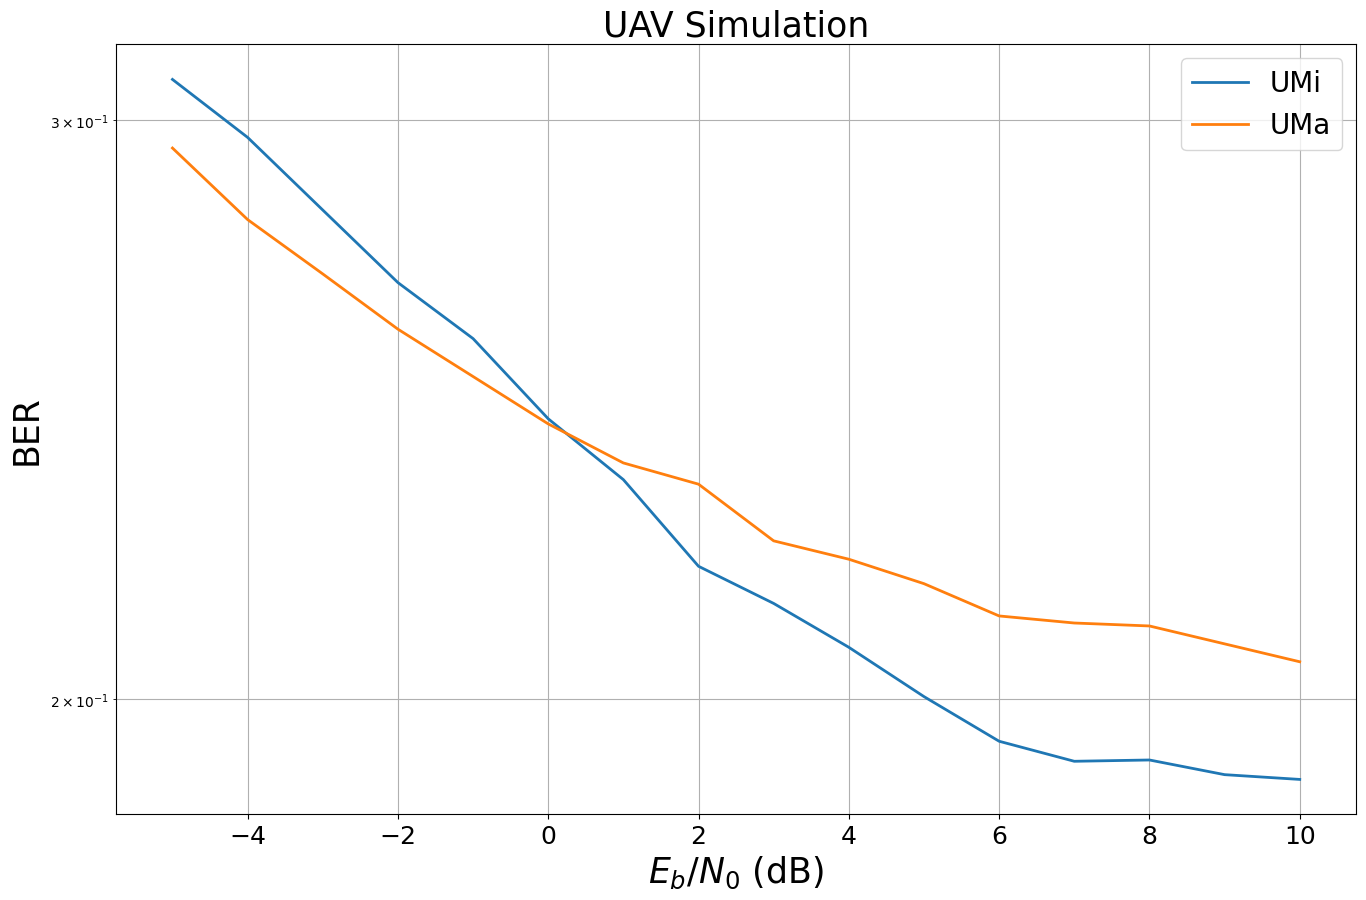

In [9]:
ber_plots();